# Processamento de Linguagem Natural (NLP)

Professor Carlos Araújo (ou Aragão?)

Notebook construído seguindo as aulas de 1 até 4.

Algumas funções são definidas cedo e começam a ser usadas com mais frequência mais tarde, como `treinar_modelo`, `grafico`, `word_cloud_neg` e `word_cloud_pos`.

## Requisitos

* Python >3.14
  * se houver incompatibilidade com versões anteriores, remova as versões das dependências em `requirements.txt` e tente novamente
* Base de dados: https://www.kaggle.com/code/abnerfreitas/nlp-buscape-data-ptbr-sentiment-analysis/input
  * baixe o arquivo `b2w.csv` e salve na pasta `data`
* Na pasta raiz, crie e ative o ambiente:
  ```
  python3 -m venv env_fase2_nlp
  source env_fase2_nlp/bin/activate
  ```
* Volte para esta pasta
  ```
  cd fase2/nlp/aulas-1-a-4
  ```
* Instale as dependências
  ```
  pip install -U pip
  pip install -r requirements.txt
  ```
* NLTK data
  * há uma célula na seção "NLTK" que faz o download de todos os dados de tokenização e stopwords desta biblioteca e que pode levar vários minutos para concluir. Este download acontece apenas uma vez por usuário local, sendo reutilizável em outros notebooks


In [178]:
import pandas as pd

avaliacoes = pd.read_csv("./data/b2w.csv")

avaliacoes.head()

original_index                                        review_text  \
0           11955  Bem macio e felpudo...recomendo.  Preço imbatí...   
1           35478  Produto excepcional!  recomendo!!! inovador e ...   
2          122760  recebi o produto antes do prazo mas veio com d...   
3           17114  Bom custo beneficio. Adequado para pessoas que...   
4           19112  Além de higiênico tem o tamanho ideal. Só falt...   

                               review_text_processed  \
0  bem macio e felpudo...recomendo.  preco imbati...   
1  produto excepcional!  recomendo!!! inovador e ...   
2  recebi o produto antes do prazo mas veio com d...   
3  bom custo beneficio. adequado para pessoas que...   
4  alem de higienico tem o tamanho ideal. so falt...   

                               review_text_tokenized  polarity  rating  \
0  ['bem', 'macio', 'felpudo', 'recomendo', 'prec...       1.0       4   
1  ['produto', 'excepcional', 'recomendo', 'inova...       1.0       5   
2  ['recebi', 'produto', 'antes', 'do', 'prazo', ...       0.0       1   
3  ['bom', 'custo', 'beneficio', 'adequado', 'par...       1.0       5   
4  ['alem', 'de', 'higienico', 'tem', 'tamanho', ...       NaN       3   

   kfold_polarity  kfold_rating  
0               1             1  
1               1             1  
2               1             1  
3               1             1  
4              -1             1

As colunas que nos interessam são:
* `review_text`: texto com avaliação do comprador
* `polarity`: sentimento (1 = positivo, 0 = negativo)

In [179]:
avaliacoes = avaliacoes.drop(
    [
        "original_index",
        "review_text_processed",
        "review_text_tokenized",
        "rating",
        "kfold_polarity",
        "kfold_rating",
    ],
    axis=1,
)

In [180]:
avaliacoes.head()

review_text  polarity
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0
1  Produto excepcional!  recomendo!!! inovador e ...       1.0
2  recebi o produto antes do prazo mas veio com d...       0.0
3  Bom custo beneficio. Adequado para pessoas que...       1.0
4  Além de higiênico tem o tamanho ideal. Só falt...       NaN

Removendo valores nulos.

In [181]:
avaliacoes.dropna(inplace=True)
avaliacoes.shape

(116058, 2)

In [182]:
avaliacoes.polarity.value_counts()

polarity
1.0    80300
0.0    35758
Name: count, dtype: int64

Preparando para treinar um modelo de regressão logística.

In [183]:
from sklearn.model_selection import train_test_split

treino, teste, classe_treino, classe_teste = train_test_split(
    avaliacoes.review_text,
    avaliacoes.polarity,
    stratify=avaliacoes.polarity,
    random_state=42,
)

In [184]:
classe_treino.value_counts()

polarity
1.0    60225
0.0    26818
Name: count, dtype: int64

In [185]:
classe_teste.value_counts()

polarity
1.0    20075
0.0     8940
Name: count, dtype: int64

Executando o treinamento diretamente com as colunas de texto... spoiler: não vai funcionar!

In [186]:
from traceback import print_exception
from sklearn.linear_model import LogisticRegression

# import traceback

regressao_logistica = LogisticRegression()

try:
    regressao_logistica.fit(treino, classe_treino)
    acuracia = regressao_logistica.score(teste, classe_teste)
    print(acuracia)
except Exception as e:
    print_exception(e, colorize=True)

Traceback (most recent call last):
  File "/var/folders/rt/9k9phhs52433jpd07v54qjj00000gn/T/ipykernel_8739/3541104242.py", line 9, in <module>
    regressao_logistica.fit(treino, classe_treino)
    ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leanderseefeld/workspaces/fiap/fiap-ia-para-devs/env_fase2_nlp/lib/python3.14/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/leanderseefeld/workspaces/fiap/fiap-ia-para-devs/env_fase2_nlp/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py", line 1191, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        accept_large_sparse=solver not in ["liblinear", "sag", "saga"],
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/leanderseefeld/workspaces/fiap/fiap-ia-para-devs/env_fase2_nlp/lib/python3.14/site-packages/sklearn/utils/validation.py", line

Regressão linear trabalha com números, não texto :)

# Vetorizador

Vamos usar o conceito de Bag of Words para representar as palavras em números, onde cada palavra vira uma coluna/feature, e cada avaliação/registro é representado pela contagem de cada palavra.

In [187]:
from sklearn.feature_extraction.text import CountVectorizer

texto = ["Este produto é muito bom", "Este produto é muito ruim"]
vetorizador = CountVectorizer()

bag_of_words = vetorizador.fit_transform(texto)

In [188]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(
    bag_of_words, columns=[vetorizador.get_feature_names_out()]
)
matriz_esparsa

bom este muito produto ruim
0   1    1     1       1    0
1   0    1     1       1    1

Partindo para os dados reais!

In [189]:
vetorizador = CountVectorizer()
bag_of_words = vetorizador.fit_transform(avaliacoes.review_text)

bag_of_words.shape

(116058, 50508)

O segundo valor indica que foram identificadas 50.508 palavras únicas!
Isso pode inviabilizazr a análise.

Vamos limitar as palavras usando o parâmetro `max_features`!

In [190]:
vetorizador = CountVectorizer(max_features=100)
bag_of_words = vetorizador.fit_transform(avaliacoes.review_text)

bag_of_words.shape

(116058, 100)

Agora sim, vamos aplicar a regressão logística novamente.

In [191]:
treino, teste, classe_treino, classe_teste = train_test_split(
    bag_of_words,
    avaliacoes.polarity,
    stratify=avaliacoes.polarity,
    random_state=42)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)

acuracia = regressao_logistica.score(teste, classe_teste)
print(acuracia)

0.8881268309495088


Não está péssimo, mas pode melhorar.

Vamos criar um método para facilitar o treinamento enquanto exploramos outras soluções.

In [192]:
def treinar_modelo(dados, coluna_texto, coluna_sentimento):
    vetorizador = CountVectorizer(max_features=100)
    bag_of_words = vetorizador.fit_transform(dados[coluna_texto])

    treino, teste, classe_treino, classe_teste = train_test_split(
        bag_of_words,
        dados[coluna_sentimento],
        stratify=dados[coluna_sentimento],
        random_state=42,
    )

    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(treino, classe_treino)

    return regressao_logistica.score(teste, classe_teste)

In [193]:
treinar_modelo(avaliacoes, "review_text", "polarity")

0.8881268309495088

# WordCloud

WordCloud é um método visual para exibir as palavras mais frequentes no corpus textual (é assim que chamamos nossa base de texto).

In [194]:
from wordcloud import WordCloud

# Transformar a coluna "review_text" em uma lista
todas_avaliacoes = [texto for texto in avaliacoes.review_text]
avaliacoes_concatenadas = ' '.join(todas_avaliacoes)

print("Quantidade de avaliações:", len(todas_avaliacoes))
print("Quantidade aprox. de palavras:", len(avaliacoes_concatenadas.split(' ')))

Quantidade de avaliações: 116058
Quantidade aprox. de palavras: 2810348


In [195]:
nuvem_palavras = WordCloud().generate(avaliacoes_concatenadas)

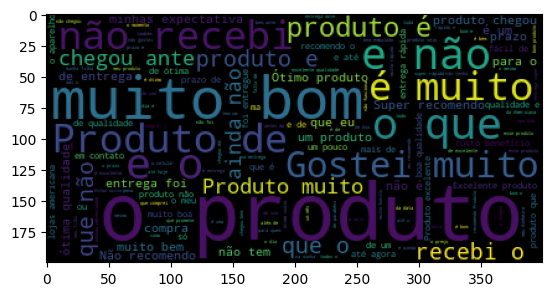

In [196]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(nuvem_palavras)

A imagem está com baixa qualidade. Vamos melhorar isso.

In [197]:
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110).generate(
    avaliacoes_concatenadas
)

(np.float64(-0.5), np.float64(799.5), np.float64(499.5), np.float64(-0.5))

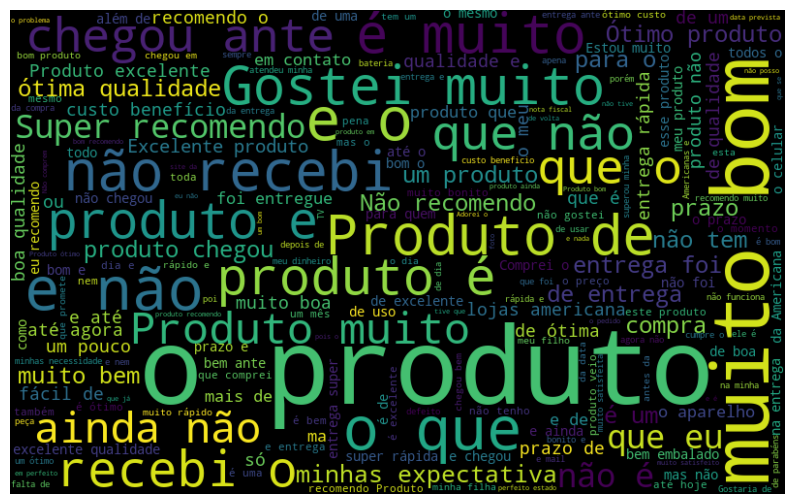

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation="bilinear")
plt.axis("off")

E criar uma função para wordclouds, separando as avaliações positivas das negativas.

In [199]:
def word_cloud_neg(dados, coluna_texto):
    texto_negativo = dados.query("polarity == 0")
    todas_avaliacoes = [texto for texto in texto_negativo[coluna_texto]]
    avaliacoes_concatenadas = " ".join(todas_avaliacoes)
    nuvem_palavras = WordCloud(
        width=800, height=500, max_font_size=110, collocations=False
    ).generate(avaliacoes_concatenadas)

    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def word_cloud_pos(dados, coluna_texto):
    texto_negativo = dados.query("polarity == 1")
    todas_avaliacoes = [texto for texto in texto_negativo[coluna_texto]]
    avaliacoes_concatenadas = " ".join(todas_avaliacoes)
    nuvem_palavras = WordCloud(
        width=800, height=500, max_font_size=110, collocations=False
    ).generate(avaliacoes_concatenadas)

    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation="bilinear")
    plt.axis("off")
    plt.show()

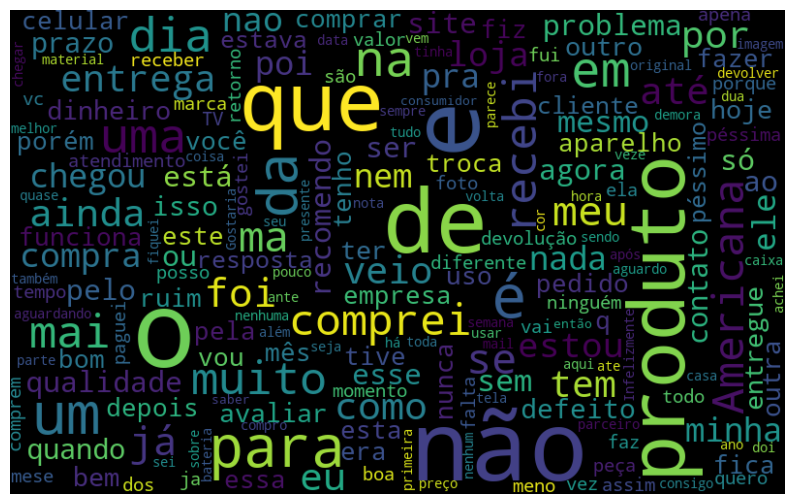

In [200]:
word_cloud_neg(avaliacoes, "review_text")

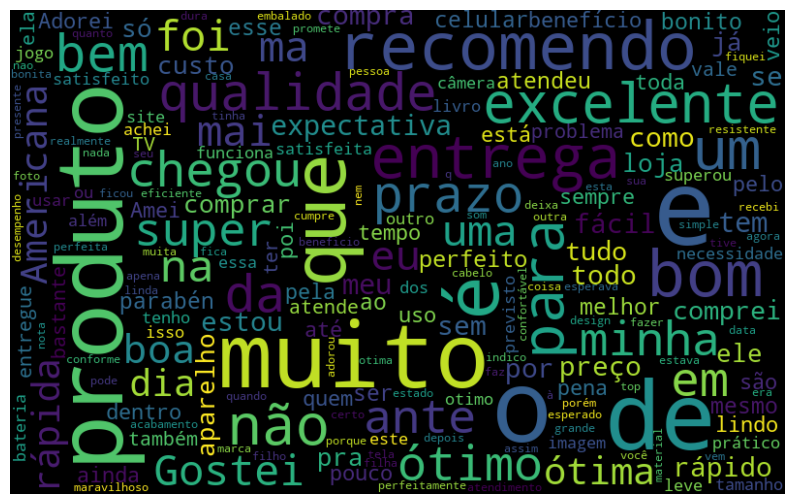

In [201]:
word_cloud_pos(avaliacoes, "review_text")

# NLTK

Consultando o WordCloud, ficou visível que temos muitas palavras que não representam o sentimento da avaliação, como: o, a, e, eu, se, isso...
Vamos aprimorar nossa análise usando a NLTK - Natural Language ToolKit

Primeiramente, vamos baixar os dados da biblioteca.

In [202]:
import nltk

nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/leanderseefeld/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/leanderseefeld/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/leanderseefeld/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/leanderseefeld/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/leanderseefeld/nltk_data...
[nltk_data]    |   Package averaged_perceptron

True

Vamos usar `FreqDist` para trazer para uma variável a frequência das palavras.

In [203]:
corpus = ["Muito bom este produto", "Muito ruim este produto"]
frequencia = nltk.FreqDist(corpus)
frequencia

FreqDist({'Muito bom este produto': 1, 'Muito ruim este produto': 1})

Isso contou a frequência das frases. Queremos a frequência das palavras!

Primeiramente, vamos usar um tokenizador simples, por espaço.

In [204]:
from nltk import tokenize

frase = "Muito bom este produto"
token_por_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_por_espaco.tokenize(frase)
token_frase

['Muito', 'bom', 'este', 'produto']

In [205]:
token_por_espaco = tokenize.WhitespaceTokenizer()
token_dataset = token_por_espaco.tokenize(avaliacoes_concatenadas)
frequencia = nltk.FreqDist(token_dataset)
frequencia

FreqDist({'e': 89308, 'o': 76053, 'de': 75791, 'a': 66640, 'que': 53574, 'não': 44253, 'do': 36776, 'muito': 36566, 'é': 36314, 'produto': 34983, ...})

Muitas palavras que não nos dizem nada sobre o real sentimento das avaliações.
O próximo passo é remover estas palavras.


In [206]:
dataframe_frequencia = pd.DataFrame(
    {"Palavra": list(frequencia.keys()), "Frequencia": list(frequencia.values())}
)

In [207]:
dataframe_frequencia.sort_values(by="Frequencia", ascending=False).head()

Palavra  Frequencia
2        e       89308
20       o       76053
17      de       75791
39       a       66640
50     que       53574

Outra forma de consultar as palavras mais frequentes:

In [208]:
dataframe_frequencia.nlargest(columns="Frequencia", n=10)

Palavra  Frequencia
2         e       89308
20        o       76053
17       de       75791
39        a       66640
50      que       53574
33      não       44253
23       do       36776
43    muito       36566
60        é       36314
21  produto       34983

Apresentando os mesmos resultados na forma de um gráfico.

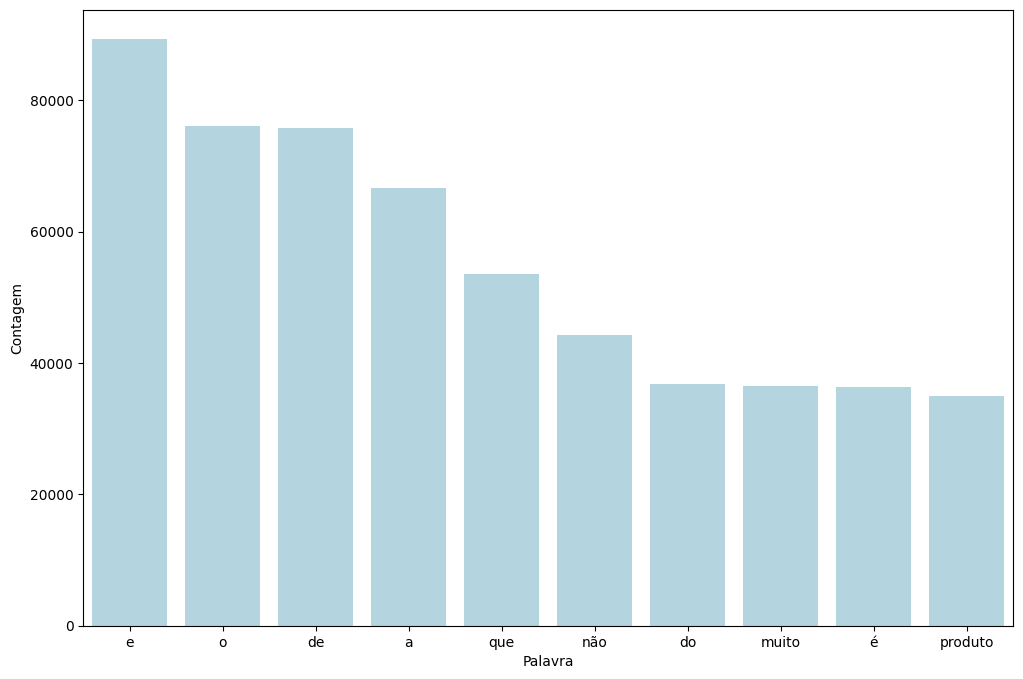

In [209]:
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=dataframe_frequencia.nlargest(columns="Frequencia", n=10),
    x="Palavra",
    y="Frequencia",
    color="lightblue",
)
ax.set(ylabel="Contagem")
plt.show()

Criando um método pra resumir o processo de concatenar as frases, tokenizar por espaço, contar as frequências e exibir o gráfico.

In [210]:
def grafico(dados, coluna_texto, quantidade):
    todas_palavras = " ".join([texto for texto in dados[coluna_texto]])
    token_frase = token_por_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)

    dataframe_frequencia = pd.DataFrame(
        {"Palavra": list(frequencia.keys()), "Frequencia": list(frequencia.values())}
    )
    dataframe_frequencia = dataframe_frequencia.nlargest(
        columns="Frequencia", n=quantidade
    )

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=dataframe_frequencia,
        x="Palavra",
        y="Frequencia",
        color="lightblue",
    )
    ax.set(ylabel="Contagem")
    plt.show()

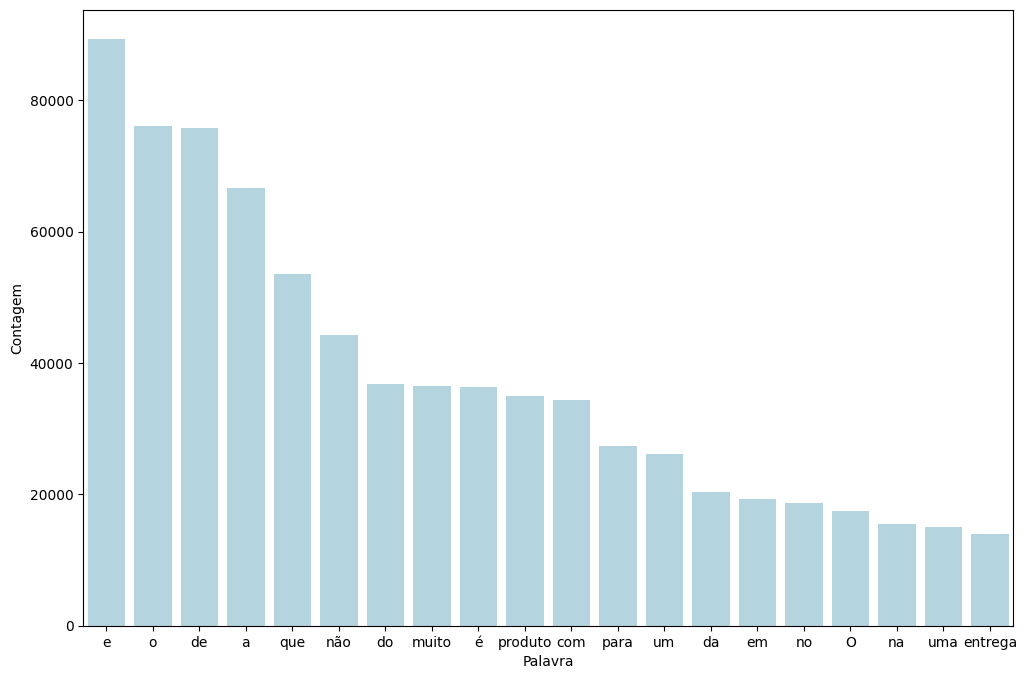

In [211]:
grafico(avaliacoes, "review_text", 20)

# Remoção de stop words

A biblioteca NLTK disponibiliza (após o download dos dados) uma lista de stopwords para vários idiomas.

In [212]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
palavras_irrelevantes

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

Vamos remover "manualmente" as stopwords do nosso corpus textual usando esta lista.

In [213]:
frase_processada = list()
for avaliacao in avaliacoes.review_text:
    nova_frase = list()
    palavras_texto = token_por_espaco.tokenize(avaliacao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(" ".join(nova_frase))
avaliacoes["texto_sem_stopwords"] = frase_processada

In [214]:
avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  
0  Bem macio felpudo...recomendo. Preço imbatível...  
1  Produto excepcional! recomendo!!! inovador gos...  
2  recebi produto antes prazo veio defeito trava ...  
3  Bom custo beneficio. Adequado pessoas fazem us...  
5  ótmo produto atendeu expectativas, entrega oco...

A regressão linear melhorou?

In [215]:
treinar_modelo(avaliacoes, "texto_sem_stopwords", "polarity")

0.8823022574530416

Ainda não... até piorou um pouquinho.

Vamos verificar novamente as palavras mais frequentes.

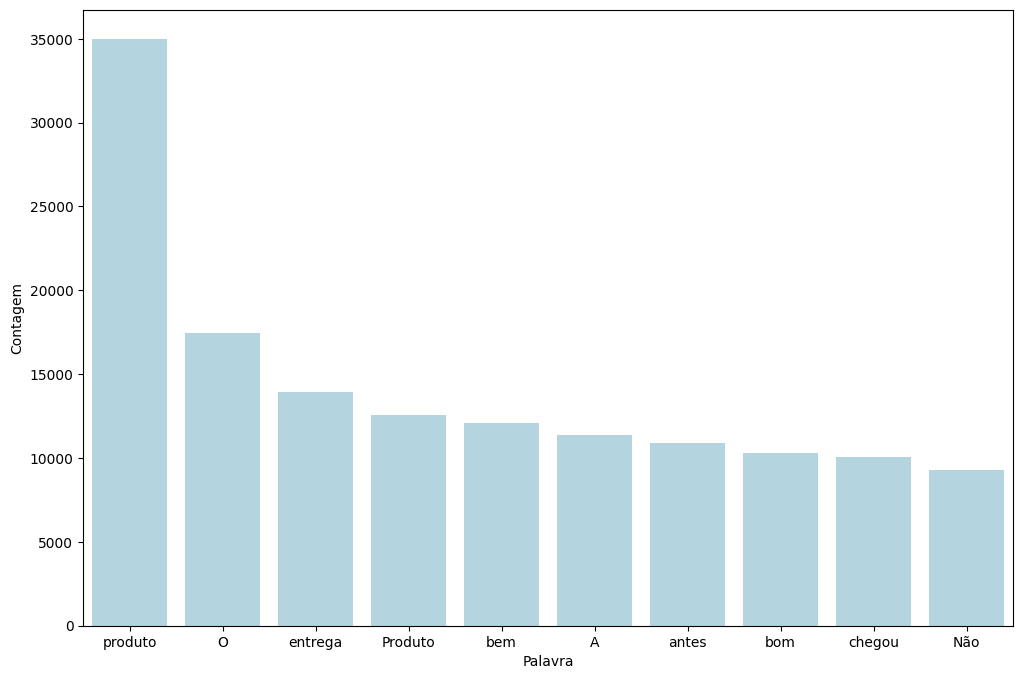

In [216]:
grafico(avaliacoes, "texto_sem_stopwords", 10)

Ainda temos stopwords! Elas estão com maiúsculas. Nosso tratamento manual também não verifica pontuações e nem sinais.
Vamos usar outro método para tratar tudo isso.

In [217]:
from nltk import tokenize

frase = "Muito bom, esse produto."
token_pontuacao = tokenize.WordPunctTokenizer()

token_frase = token_pontuacao.tokenize(frase)
token_frase

['Muito', 'bom', ',', 'esse', 'produto', '.']

Pontuação, aqui, também está sendo considerada como token. Isso pode ser desejável a depender do modelo, mas não no nosso caso.

O que é considerado pontuação:

In [218]:
from string import punctuation

punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Agora, vamos remover todas as stopwords e também a pontuação do nosso corpus textual.

Repare que agora usaremos a coluna `texto_sem_stopwords`, gerado anteriormente.

In [219]:
pontuacao = [ponto for ponto in punctuation]
pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for avaliacao in avaliacoes.texto_sem_stopwords:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(avaliacao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(" ".join(nova_frase))

avaliacoes["texto_sem_stopwords_e_pontuacao"] = frase_processada

In [220]:
avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  \
0  Bem macio felpudo...recomendo. Preço imbatível...   
1  Produto excepcional! recomendo!!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio. Adequado pessoas fazem us...   
5  ótmo produto atendeu expectativas, entrega oco...   

                     texto_sem_stopwords_e_pontuacao  
0  Bem macio felpudo ... recomendo Preço imbatíve...  
1  Produto excepcional recomendo !!! inovador gos...  
2  recebi produto antes prazo veio defeito trava ...  
3  Bom custo beneficio Adequado pessoas fazem uso...  
5  ótmo produto atendeu expectativas entrega ocor...

Ainda ficamos com alguns resíduos, como `!!!`
Usando esta abordagem, precisaríamos incluir esta string em nossa lista de pontuações. 

Mas vamos apenas assumir, por enquanto, que a frequência dessa e outras strings similares não teriam impacto relevante no nosso modelo.

Comparando uma mesma frase com o antes e depois de remover a pontuação:

In [221]:
print(avaliacoes.texto_sem_stopwords[5])
print(avaliacoes.texto_sem_stopwords_e_pontuacao[5])

ótmo produto atendeu expectativas, entrega ocorreu antes previsto. bom
ótmo produto atendeu expectativas entrega ocorreu antes previsto bom


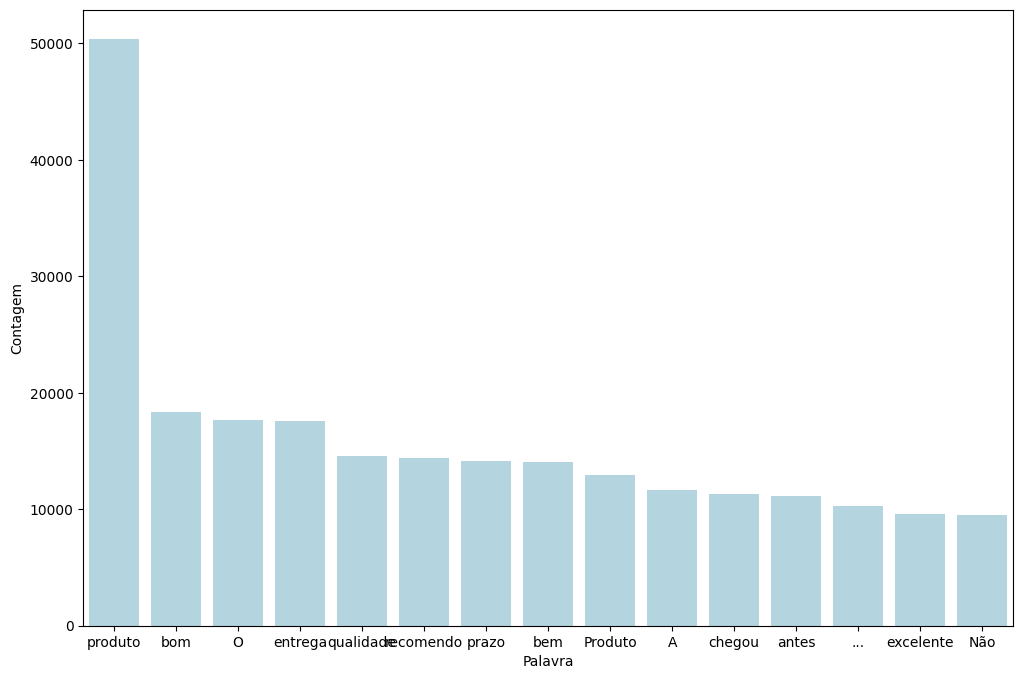

In [222]:
grafico(avaliacoes, "texto_sem_stopwords_e_pontuacao", 15)

Percebe-se que a palavra "bom" passou a constar no gráfico. É provável que antes desse tratamento ela estive frequentemente seguida de pontuação (ponto ou vírgula).

# Parte 3

Vamos remover acentos para melhor uniformizar as palavras.

Vamos usar a lib `unidecode` para isso.

In [223]:
!pip install unidecode

In [224]:
import unidecode

acentos = "ótimo péssimo não tão é"

unidecode.unidecode(acentos)

'otimo pessimo nao tao e'

Vamos aplicar isso ao nosso texto já tratado.

In [225]:
sem_acentos = [unidecode.unidecode(texto) for texto in avaliacoes.texto_sem_stopwords_e_pontuacao]

print(avaliacoes.texto_sem_stopwords_e_pontuacao[5])
print(sem_acentos[4])

ótmo produto atendeu expectativas entrega ocorreu antes previsto bom
otmo produto atendeu expectativas entrega ocorreu antes previsto bom


Vamos adicionar stopwords sem seus acentos à nossa lista de exclusão.

In [226]:
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in palavras_irrelevantes]
stopwords_sem_acento

['a',
 'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'as',
 'ate',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'eramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'esta',
 'estamos',
 'estao',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estavamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiveramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivessemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'foramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fossemos',
 'fui',
 'ha',
 'haja',
 'hajam',
 'hajamos',
 'hao',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houvera',
 'houveram',
 'houveramos',
 'houverao',
 'houverei',
 'houverem',
 'hou

In [227]:
avaliacoes["texto_sem_stopwords_e_pontuacao_e_acentos"] = sem_acentos

frase_processada = list()
for avaliacao in avaliacoes.texto_sem_stopwords_e_pontuacao_e_acentos:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(avaliacao)
    for palavra in palavras_texto:
        # Lembrando que nessa estágio nós já removemos a pontuação, então podemos excluir apenas as stopwords tratadas
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(" ".join(nova_frase))

avaliacoes["texto_sem_stopwords_e_pontuacao_e_acentos"] = frase_processada

In [228]:
avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  \
0  Bem macio felpudo...recomendo. Preço imbatível...   
1  Produto excepcional! recomendo!!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio. Adequado pessoas fazem us...   
5  ótmo produto atendeu expectativas, entrega oco...   

                     texto_sem_stopwords_e_pontuacao  \
0  Bem macio felpudo ... recomendo Preço imbatíve...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  ótmo produto atendeu expectativas entrega ocor...   

           texto_sem_stopwords_e_pontuacao_e_acentos  
0  Bem macio felpudo ... recomendo Preco imbative...  
1  Produto excepcional recomendo !!! inovador gos...  
2  recebi produto antes prazo veio defeito trava ...  
3  Bom custo beneficio Adequado pessoas fazem uso...  
5  otmo produto atendeu expectativas entrega ocor...

Treinando o modelo pra verificar...

In [229]:
treinar_modelo(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos", "polarity")

0.8829226262278131

Ainda não melhorou.

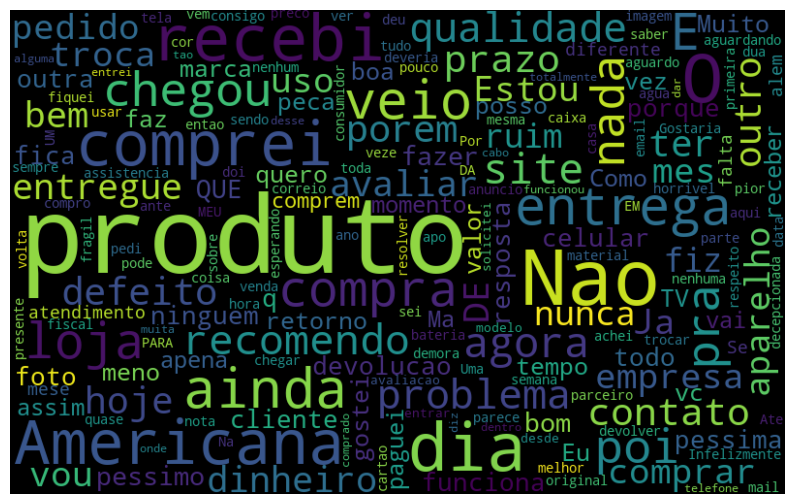

In [230]:
word_cloud_neg(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos")

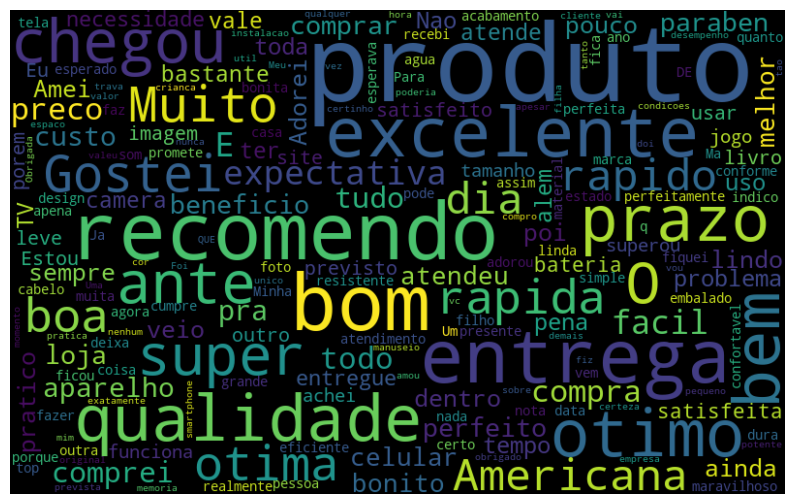

In [231]:
word_cloud_pos(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos")

Na wordcloud negativa, podemos ver que "Nao" aparece em destaque, mesmo sendo uma stopword.
Demorou muito pro professor abordar isso, mas finalmente ele vai falar sobre transformar tudo em minúsculo.

In [232]:
frase = "O Rato Roeu a Roupa do Rei de Roma"
frase.lower()

'o rato roeu a roupa do rei de roma'

In [233]:
frase_processada = list()
for avaliacao in avaliacoes.texto_sem_stopwords_e_pontuacao_e_acentos:
    avaliacao = avaliacao.lower()
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(avaliacao)
    for palavra in palavras_texto:
        # Lembrando que nessa estágio nós já removemos a pontuação, então podemos excluir apenas as stopwords tratadas
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(" ".join(nova_frase))

avaliacoes["texto_sem_stopwords_e_pontuacao_e_acentos_minusculo"] = frase_processada

In [234]:
avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  \
0  Bem macio felpudo...recomendo. Preço imbatível...   
1  Produto excepcional! recomendo!!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio. Adequado pessoas fazem us...   
5  ótmo produto atendeu expectativas, entrega oco...   

                     texto_sem_stopwords_e_pontuacao  \
0  Bem macio felpudo ... recomendo Preço imbatíve...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  ótmo produto atendeu expectativas entrega ocor...   

           texto_sem_stopwords_e_pontuacao_e_acentos  \
0  Bem macio felpudo ... recomendo Preco imbative...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  otmo produto atendeu expectativas entrega ocor...   

  texto_sem_stopwords_e_pontuacao_e_acentos_minusculo  
0  bem macio felpudo ... recomendo preco imbative...   
1  produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  bom custo beneficio adequado pessoas fazem uso...   
5  otmo produto atendeu expectativas entrega ocor...

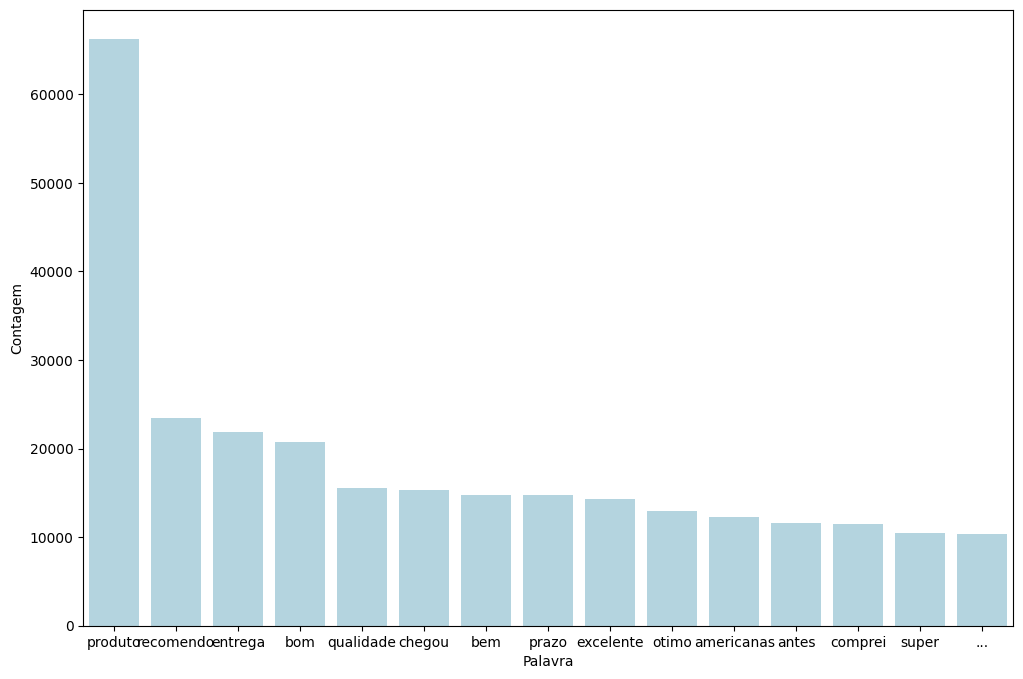

In [235]:
grafico(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos_minusculo", 15)

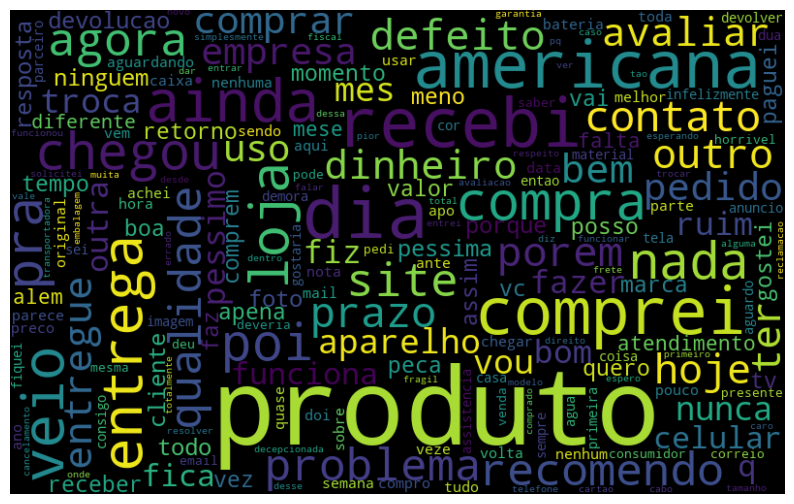

In [236]:
word_cloud_neg(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos_minusculo")

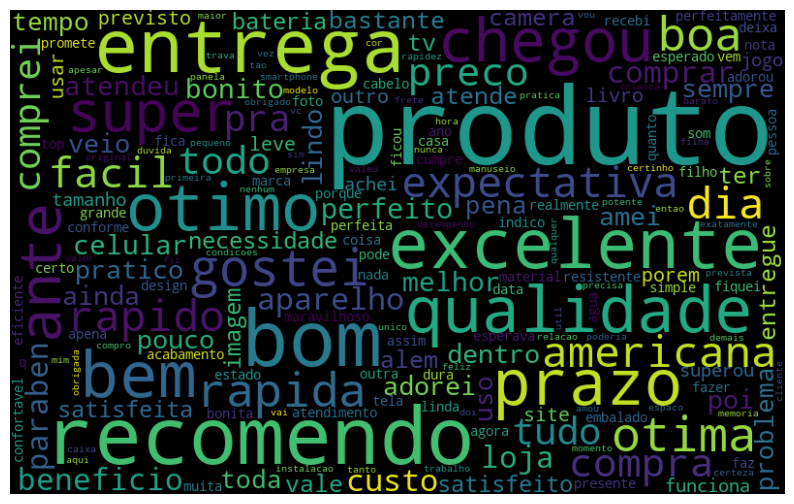

In [237]:
word_cloud_pos(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos_minusculo")

In [238]:
treinar_modelo(avaliacoes, "texto_sem_stopwords_e_pontuacao_e_acentos_minusculo", "polarity")

0.8731690504911253

A acurácia do modelo caiu ainda mais.
Não foi dada uma explicação pra isso, mas na próxima aula vamos explorar o conceito de _stemming_ pra trabalhar melhor com as palavras.

O que eu penso:

Por estarmos usando bag-of-words e trabalhando apenas com contagem de frequência das palavras, ao "compactar" nosso dicionário e alterar essas frequências, o modelo fica com menos "indicadores" de uma boa avaliação. Além do mais, remover palavras como "não" pode mudar completamente o sentido de uma frase (de "não gostei" para apenas "gostei").

Vale também consultar a documentação do `CountVectorizer`. Podemos ver que ele já trabalha com transformação para minúsculas por padrão, e nos exemplos no começo deste _notebook_, percebo que ele já remove stopwords como "é". 

In [239]:
"não" in palavras_irrelevantes

True

# Aula 4 - Stemming, TF IDF e NGrams

## Parte 1 - Stemming

Vamos aplicar stemming para reduzir as palavras a sua forma comum.

Vamos aplicar RSLP para isso. Vale notar que cada idioma pode usar um padrão diferente e vamos focar apenas no português.

RSLP = portugues
porter = ingles

In [240]:
stemmer = nltk.RSLPStemmer()

print(stemmer.stem("Corredor"))
print(stemmer.stem("Corre"))
print(stemmer.stem("Correria"))

corr
corr
corr


In [241]:
avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  \
0  Bem macio felpudo...recomendo. Preço imbatível...   
1  Produto excepcional! recomendo!!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio. Adequado pessoas fazem us...   
5  ótmo produto atendeu expectativas, entrega oco...   

                     texto_sem_stopwords_e_pontuacao  \
0  Bem macio felpudo ... recomendo Preço imbatíve...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  ótmo produto atendeu expectativas entrega ocor...   

           texto_sem_stopwords_e_pontuacao_e_acentos  \
0  Bem macio felpudo ... recomendo Preco imbative...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  otmo produto atendeu expectativas entrega ocor...   

  texto_sem_stopwords_e_pontuacao_e_acentos_minusculo  
0  bem macio felpudo ... recomendo preco imbative...   
1  produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  bom custo beneficio adequado pessoas fazem uso...   
5  otmo produto atendeu expectativas entrega ocor...

In [242]:
frase_processada = list()
for avaliacao in avaliacoes.texto_sem_stopwords_e_pontuacao_e_acentos_minusculo:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(avaliacao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(" ".join(nova_frase))

avaliacoes["texto_stemmizado"] = frase_processada

avaliacoes.head()

review_text  polarity  \
0  Bem macio e felpudo...recomendo.  Preço imbatí...       1.0   
1  Produto excepcional!  recomendo!!! inovador e ...       1.0   
2  recebi o produto antes do prazo mas veio com d...       0.0   
3  Bom custo beneficio. Adequado para pessoas que...       1.0   
5  ótmo produto atendeu as expectativas, a entreg...       1.0   

                                 texto_sem_stopwords  \
0  Bem macio felpudo...recomendo. Preço imbatível...   
1  Produto excepcional! recomendo!!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio. Adequado pessoas fazem us...   
5  ótmo produto atendeu expectativas, entrega oco...   

                     texto_sem_stopwords_e_pontuacao  \
0  Bem macio felpudo ... recomendo Preço imbatíve...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  ótmo produto atendeu expectativas entrega ocor...   

           texto_sem_stopwords_e_pontuacao_e_acentos  \
0  Bem macio felpudo ... recomendo Preco imbative...   
1  Produto excepcional recomendo !!! inovador gos...   
2  recebi produto antes prazo veio defeito trava ...   
3  Bom custo beneficio Adequado pessoas fazem uso...   
5  otmo produto atendeu expectativas entrega ocor...   

  texto_sem_stopwords_e_pontuacao_e_acentos_minusculo  \
0  bem macio felpudo ... recomendo preco imbative...    
1  produto excepcional recomendo !!! inovador gos...    
2  recebi produto antes prazo veio defeito trava ...    
3  bom custo beneficio adequado pessoas fazem uso...    
5  otmo produto atendeu expectativas entrega ocor...    

                                    texto_stemmizado  
0  bem maci felpud ... recom prec imbati entreg r...  
1           produt excepc recom !!! inov gost ler !!  
2  receb produt ant praz vei defeit tr us agor am...  
3  bom cust benefici adequ pesso faz uso cas apar...  
5  otm produt atend expect entreg ocorr ant previ...

In [243]:
treinar_modelo(avaliacoes, "texto_stemmizado", "polarity")

0.8875753920386007

Melhorou um pouco!

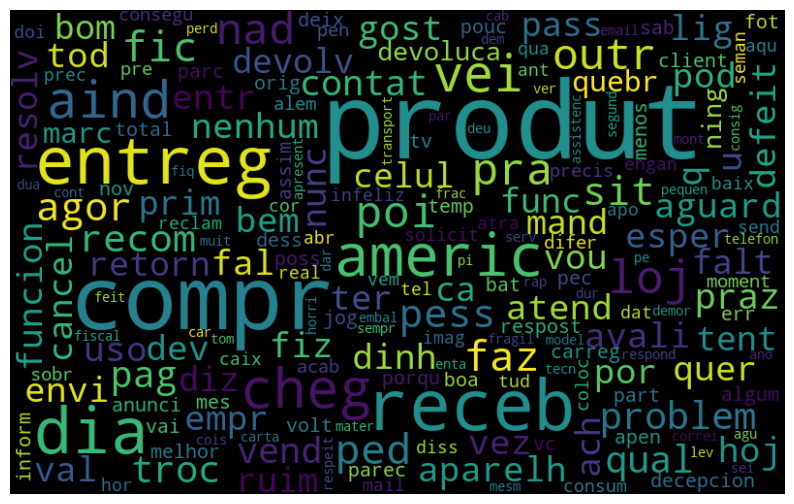

In [244]:
word_cloud_neg(avaliacoes, "texto_stemmizado")

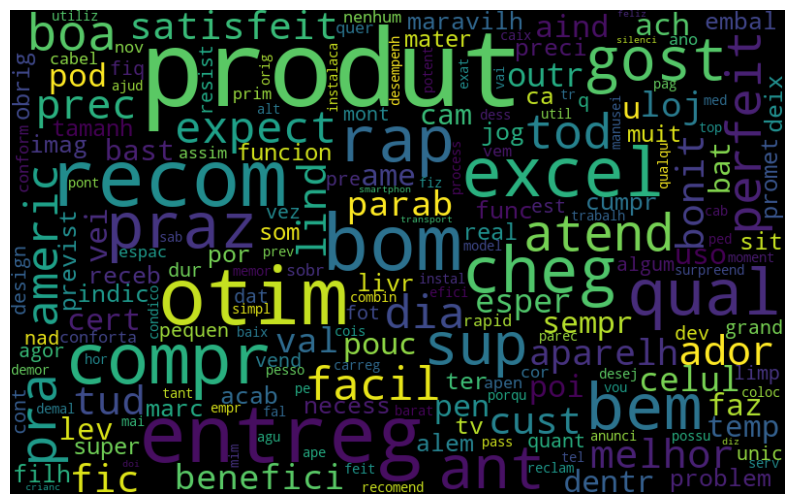

In [245]:
word_cloud_pos(avaliacoes, "texto_stemmizado")

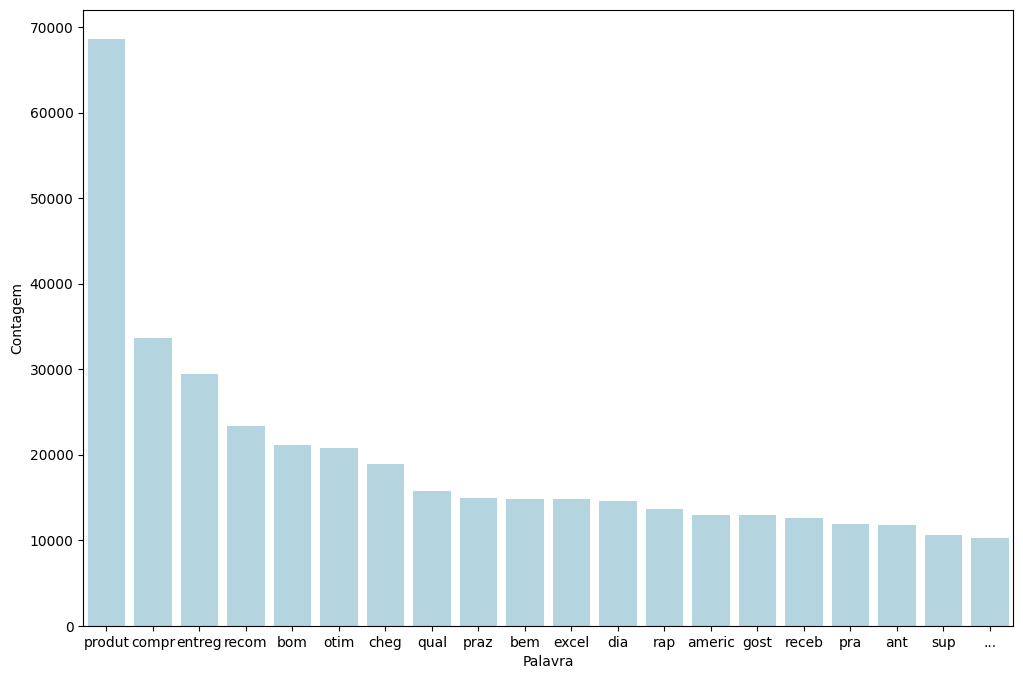

In [246]:
grafico(avaliacoes, "texto_stemmizado", 20)

## Parte 2 - TF IDF

**TF-IDF (Term Frequency – Inverse Document Frequency)** é uma métrica usada em NLP para medir o quão importante uma palavra é em um documento dentro de um conjunto de documentos (corpus).

### Ideia central
Uma palavra é relevante se:
- aparece bastante no documento (alta frequência local),
- mas não aparece em todos os documentos (baixa frequência global).

### Componentes

**TF (Term Frequency)** — frequência do termo no documento  
Mede quantas vezes a palavra aparece no texto.  
Exemplo: ocorrências do termo / total de termos do documento.

**IDF (Inverse Document Frequency)** — raridade do termo no corpus  
Dá mais peso a termos raros e menos peso a termos muito comuns.

Fórmula comum:

IDF = log(N / df)

Onde:
- `N` = número total de documentos  
- `df` = número de documentos que contêm o termo

### Fórmula final

TF-IDF = TF × IDF

### Intuição prática

- Palavras muito comuns (“de”, “o”, “e”) → TF alto, IDF baixo → peso final baixo  
- Palavras específicas do tema → TF moderado, IDF alto → peso final alto

### Uso típico

- Vetorização de texto
- Busca de informação
- Classificação de documentos
- Clustering
- Cálculo de similaridade entre textos

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer

frases = ["Este produto é muito bom", "Este produto é muito ruim"]

tfidf = TfidfVectorizer(lowercase=False, max_features=100)
caracteristicas = tfidf.fit_transform(frases)

pd.DataFrame(
    caracteristicas.todense(),
    columns=tfidf.get_feature_names_out()
)

Este       bom     muito   produto      ruim
0  0.448321  0.630099  0.448321  0.448321  0.000000
1  0.448321  0.000000  0.448321  0.448321  0.630099

In [248]:
tfidf_tratados = tfidf.fit_transform(avaliacoes.texto_stemmizado)

treino, teste, classe_treino, classe_teste = train_test_split(
    tfidf_tratados, avaliacoes.polarity, random_state=42, stratify=avaliacoes.polarity
)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)

acuracia_tfidf = regressao_logistica.score(teste, classe_teste)

acuracia_tfidf

0.8879545062898501

Aumentou tão pouquinho 🤏 (0.0004)

## Parte 3 - Ngrams

Algumas palavras só fazem sentido acompanhadas de outras (duas palavras = bigrama, três = trigrama...)

Exemplo:

In [249]:
from nltk import ngrams

frase = "Comprei um ótimo produto"
frase_separada = token_por_espaco.tokenize(frase)
pares = ngrams(frase_separada, 2)

list(pares)

[('Comprei', 'um'), ('um', 'ótimo'), ('ótimo', 'produto')]

Ficar atento para o uso de ngramas pois isso aumenta a quantidade de dados a serem processados pelos modelos de aprendizagem! (problema da alta dimensionalidade)

In [250]:
tfidf = TfidfVectorizer(lowercase=False, max_features=100, ngram_range=(1, 2))
caracteristicas = tfidf.fit_transform(frases)

print("\n".join(frases))

pd.DataFrame(
    caracteristicas.todense(),
    columns=tfidf.get_feature_names_out()
)

Este produto é muito bom
Este produto é muito ruim


Este  Este produto       bom     muito  muito bom  muito ruim  \
0  0.334251      0.334251  0.469778  0.334251   0.469778    0.000000   
1  0.334251      0.334251  0.000000  0.334251   0.000000    0.469778   

    produto  produto muito      ruim  
0  0.334251       0.334251  0.000000  
1  0.334251       0.334251  0.469778

Agora, como implementamos isso no modelo?

In [251]:
# ngram_range = (minimo, maximo) // (1, 2) == unigramas e bigramas
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

vetor_tfidf = tfidf.fit_transform(avaliacoes.texto_stemmizado)

treino, teste, classe_treino, classe_teste = train_test_split(
    vetor_tfidf, avaliacoes.polarity, random_state=42, stratify=avaliacoes.polarity
)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
acuracia_tfidf_ngrams

0.9393761847320351

Agora sim! Tivemos uma melhora considerável na acurácia do modelo.

Vamos verificar o que mais contribuiu para o modelo!

In [252]:
pesos = pd.DataFrame(
    regressao_logistica.coef_[0].T,
    index = tfidf.get_feature_names_out()
)

pesos.nlargest(100, 0)

0
otim          18.197579
excel         16.957445
bom           13.331853
perfeit       10.978041
ador          10.439078
...                 ...
unic problem   2.174013
boa qual       2.152930
amig           2.148910
design         2.147622
lev            2.144530

[100 rows x 1 columns]

Podemos ver alguns bigramas como "unic problem" e "boa qual" que influenciaram na classificação positiva.

In [253]:
pesos.nsmallest(100, 0)

0
pess      -10.276057
ruim       -8.690549
frac       -7.636389
receb      -7.231803
decepcion  -7.169921
...              ...
falsific   -2.427127
part       -2.425491
vier       -2.415366
pec        -2.414735
car        -2.409363

[100 rows x 1 columns]

Agora, listando só os bigramas:

In [254]:
pesos[pesos.index.str.contains(" ")].nlargest(10, 0)

0
produt otim   4.505667
produt excel  4.324318
otim produt   4.085250
produt bom    3.993781
sup recom     3.678770
gost produt   3.617661
excel produt  3.518700
bom produt    3.456034
ant praz      3.334182
nad reclam    3.246411

In [255]:
pesos[pesos.index.str.contains(" ")].nsmallest(10, 0)

0
pess qual     -4.203683
baix qual     -4.050070
aind receb    -3.196824
bom dia       -3.141825
receb produt  -2.866760
dia uso       -2.676829
dinh jog      -2.455835
par funcion   -2.404228
descarreg rap -2.338217
vei defeit    -2.232820

Será que as pessoas costumam dizer "bom dia" logo antes de avaliar negativamente um produto? :)

Testando agora com trigramas!

In [256]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1, 3))

vetor_tfidf = tfidf.fit_transform(avaliacoes.texto_stemmizado)

treino, teste, classe_treino, classe_teste = train_test_split(
    vetor_tfidf, avaliacoes.polarity, random_state=42, stratify=avaliacoes.polarity
)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
acuracia_tfidf_ngrams

0.9348957435809064

Piorou um pouquinho o resultado. Dá pra concluir que fica melhor com bigramas :)